In [1]:
from PIL import Image

In [2]:
import numpy as np

In [3]:
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.model_selection import train_test_split

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.models import load_model

In [5]:
import os

In [6]:
import warnings

In [7]:
# 忽略硬件加速的警告信息
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

In [8]:
scaler = StandardScaler()

In [9]:
#读取数据
path = "./machine_learning/象棋数据集"
dirs = os.listdir(path)
im2array = []
for file in dirs:
    pic_dir = os.path.join(path,file)  #子文件夹的路径
    for i in os.listdir(pic_dir):
        image_dir = os.path.join(pic_dir,i)  #子文件夹中图片的路径
        pic = np.array(Image.open(image_dir))
        im = scaler.fit_transform(pic) #标准化
        im2array.append(im)
im_array = np.array(im2array).reshape(7190,128,128,1)
print(im_array.shape)

(7190, 128, 128, 1)


In [10]:
#生成标签
labels = np.zeros(shape = (7190,1),dtype = int)
for i in range(10):
    for j in range(719):
        labels[719*i+j][0] = i

In [11]:
#打乱数据集及数据标签
X,Y = sklearn.utils.shuffle(im_array,labels)
#print(Y[1:20])

[[7]
 [2]
 [9]
 [8]
 [0]
 [8]
 [4]
 [2]
 [6]
 [2]
 [6]
 [3]
 [3]
 [7]
 [8]
 [0]
 [8]
 [2]
 [1]]


In [12]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.4,
                                                 random_state = 0)

In [13]:
#标签转换成独热编码
y_train = keras.utils.to_categorical(y_train, num_classes = 10)
y_test = keras.utils.to_categorical(y_test, num_classes = 10)
#print(x_train.shape)
#print(y_train.shape)

(4314, 128, 128, 1)
(4314, 10)


In [14]:
#卷积神经网络模型，采用keras进行搭建
#这里使用序贯模型，比较容易理解,序贯模型就像搭积木一样，将神经网络一层一层往上搭上去
model = Sequential()
#搭一个卷积层
model.add(Conv2D(32,(3,3),activation = 'relu',padding = 'same',
                 data_format = 'channels_last',name = 'layer1_con1',
                 input_shape = (128,128,1)))
#再搭一层卷积层
model.add(Conv2D(32,(3,3),activation = 'relu',padding = 'same',
                 data_format = 'channels_last',name = 'layer1_con2'))
#搭一个最大池化层
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2),
                       padding = 'same',data_format = 'channels_last',
                       name = 'layer1_pool'))
#dropout层可以防止过拟合，每次有25%的数据将被抛弃
model.add(Dropout(0.25))
#和上面的网络结构类似
model.add(Conv2D(64,(3,3),activation = 'relu',padding = 'same',
                 data_format = 'channels_last',name = 'layer2_con1'))
model.add(Conv2D(64,(3,3),activation = 'relu',padding = 'same',
                 data_format = 'channels_last',name = 'layer2_con2'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2),
                       padding = 'same',data_format = 'channels_last',
                       name = 'layer2_pool'))
model.add(Flatten())
#该全连接层共128个神经元
model.add(Dense(128,activation = 'relu')) 
#一共分为10类，所以最后一层有10个神经元，并且采用softmax输出
model.add(Dense(10, activation='softmax'))
#定义损失值、优化器
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',
              metrics = ['accuracy'])

In [15]:
#回调函数
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                            patience = 3,mode = 'auto',
                                            verbose = 1, factor = 0.5,
                                            min_lr = 0.00001)
#TensorBoard可视化
TensorBoard = TensorBoard(log_dir = './machine_learning/log',
                          write_images = 1,histogram_freq = 1)

In [16]:
model.fit(x_train, y_train,epochs = 3,
          callbacks = [learning_rate_reduction,TensorBoard])

Epoch 1/3
135/135 [==============================] - 242s 2s/step - loss: 2.3488 - accuracy: 0.1724
Epoch 2/3
135/135 [==============================] - 209s 2s/step - loss: 0.4296 - accuracy: 0.8501
Epoch 3/3
135/135 [==============================] - 209s 2s/step - loss: 0.0629 - accuracy: 0.9837


In [17]:
#计算得分
[loss,accuracy] = model.evaluate(X_test,y_test)
print('\nTest Loss: ',loss)
print('\nTest Accuracy: ',accuracy)

90/90 [==============================] - 28s 314ms/step - loss: 0.0012 - accuracy: 1.0000

Test Loss:  0.0012084634508937597

Test Accuracy:  1.0


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


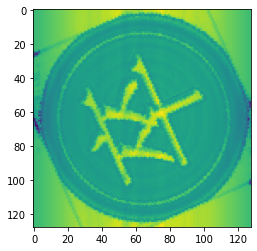

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[4])
print(y_train[4])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


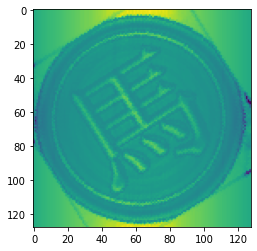

In [27]:
plt.imshow(X_test[1])
print(y_test[1])

In [48]:
model.predict(X_test[:])

array([[1.33443994e-17, 5.34992328e-10, 2.54755649e-22, ...,
        3.55961760e-07, 8.36118119e-11, 2.38200681e-13],
       [9.99910951e-01, 2.80116150e-14, 6.45629399e-08, ...,
        6.73146037e-19, 2.19693691e-19, 5.62854984e-05],
       [1.98387564e-03, 1.08554214e-10, 4.61746140e-06, ...,
        2.62002757e-14, 6.07857219e-05, 1.78174560e-06],
       ...,
       [5.85699584e-18, 4.13093932e-17, 2.19528524e-21, ...,
        8.73357122e-15, 9.99831319e-01, 5.52801586e-14],
       [2.51081233e-15, 9.00883490e-15, 1.23727426e-16, ...,
        1.03186686e-08, 8.60986256e-05, 2.50319682e-10],
       [1.17957470e-05, 3.22346425e-12, 7.60404739e-10, ...,
        4.89058316e-12, 9.99636889e-01, 1.33580645e-14]], dtype=float32)

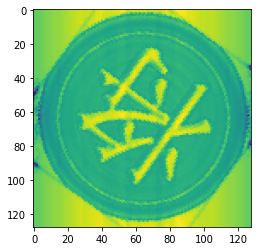

In [46]:
plt.imshow(X_test[0])